In [ ]:
VISUALIZE = True
# Step 1: Download the Sarabun font from Google Fonts
!wget -q -O Sarabun-Regular.ttf https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf
# !unzip -q -o /home/jaf/dsde/traffyfondue/train.csv.zip -d /home/jaf/dsde/traffyfondue
!pip install datasets transformers[sentencepiece] lightning scikit-learn -q

# Install iterative-stratification package (if not already installed)
!pip install iterative-stratification -q

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import pytorch_lightning as pl
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, Features, Value
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Now displaying the text won't cut it off
pd.set_option('display.max_colwidth', None)

# Step 2: Attempt to add the font to Matplotlib's font manager
try:
    fm.fontManager.addfont('Sarabun-Regular.ttf')
    # If the font is added successfully, we set the font family to 'Sarabun'
    plt.rcParams['font.family'] = 'Sarabun'
except Exception as e:
    print("Failed to add font via addfont. Using FontProperties as fallback.")
    prop = fm.FontProperties(fname='Sarabun-Regular.ttf')
    plt.rcParams['font.family'] = prop.get_name()

# Ensure minus signs display correctly
plt.rcParams['axes.unicode_minus'] = False

# Read the CSV file (ensure the file 'training.csv' is in your working directory)
df_train_raw = pd.read_csv('/home/jaf/dsde/traffyfondue/train.csv')
df_test_raw = pd.read_csv('/home/jaf/dsde/traffyfondue/test.csv')

2025-03-16 14:40:34.560140: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 14:40:34.709448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742110834.768585   15495 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742110834.784208   15495 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-16 14:40:34.938877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Introduction to dataset

In [2]:
if VISUALIZE:
    # Display the first few rows to verify data load
    print(df_train_raw.comment.head())
    
    # Display basic info about the DataFrame
    print("DataFrame Info:")
    print(df_train_raw.info())
    
    # 1. Check for duplicate rows
    duplicates = df_train_raw[df_train_raw.duplicated()]
    print(f"\nNumber of duplicate rows: {duplicates.shape[0]}")
    if not duplicates.empty:
        print("Duplicate rows:")
        display(duplicates)
    
    # 2. Check for null (missing) values in each column
    null_counts = df_train_raw.isnull().sum()
    print("\nNull values per column:")
    print(null_counts)
    
    # 3. Check for blank (empty string) entries in text columns
    # Define a helper function to count blank strings in a Series
    def count_blank(series):
        # Convert values to string and check if stripped value is empty
        return series.astype(str).str.strip().eq('').sum()
    
    # Loop over columns with object (text) data types
    print("\nBlank entries in text columns:")
    for col in df_train_raw.select_dtypes(include='object').columns:
        blanks = count_blank(df_train_raw[col])
        if blanks > 0:
            print(f"Column '{col}' has {blanks} blank entries.")

0                                                                                                                                                                                                                     บริเวณนราธิวาส  แยกถนนจันทน์ ใกล้สวนสาธารณะช่องนนทรี ทางเท้าเน่ามาก
1    บริเวณสะพานสามถนนจันทน์ เป็นจุดเปลี่ยนถ่ายสองแถวหลายสายมากมาย ทำให้สองแถวชอบจอดรอผู้โดยสาร และผู้โดยสารที่ต้องเปลี่ยนสายสองแถวก็จะมารอตรงนี้เช่นกัน ทำให้รถติด แต่ก็จำเป็นสำหรับคนในย่านมาก ถ้ามีการพัฒนาพื้นที่เปลี่ยนถ่ายให้ดี ลดการรบกวนจราจรแต่ยังตอบสนองวิถีชีวิตเดิมได้จะดีมาก
2                                                                                                                                                                                                                                  เรื่องทางม้าลายหายไป บริเวณสี่แยกถนนจันทร์-เซนต์หลุยส์
3                                                                                                                                                         

Label columns: ['สำนักงานตำรวจแห่งชาติ', 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย', 'สภาเด็กและเยาวชนกรุงเทพมหานคร', 'กรมควบคุมมลพิษ', 'กรมสรรพสามิต', 'การไฟฟ้านครหลวง', 'กรมทางหลวง', 'สำนักงานประกันสุขภาพแห่งชาติ', 'การประปานครหลวง', 'คณะกรรมการการพัฒนาเศรษฐกิจ', 'กระทรวงการท่องเที่ยวและกีฬา', 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200']


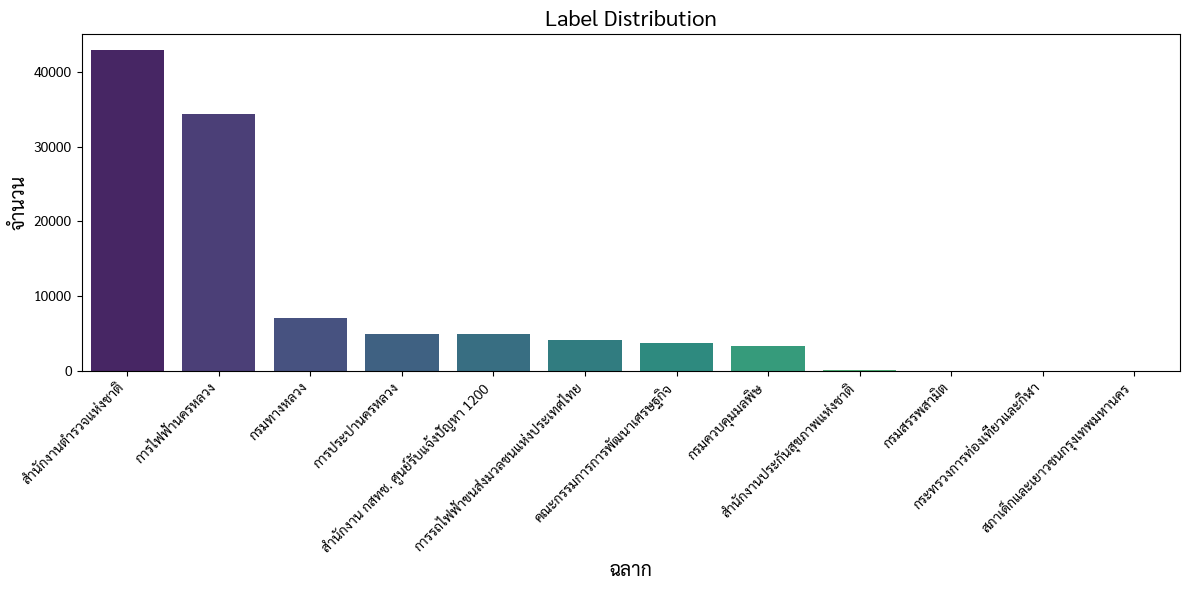

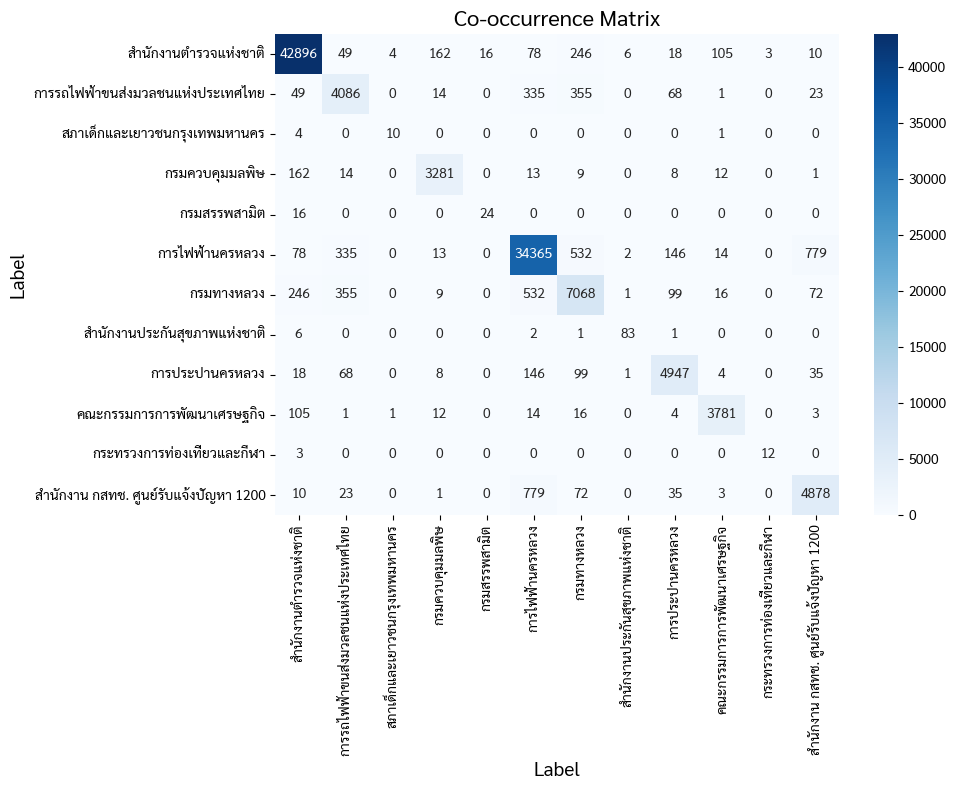

In [3]:
if VISUALIZE:
    # Identify label columns (all columns except 'id' and 'comment')
    label_columns = df_train_raw.columns[2:]
    print("Label columns:", label_columns.tolist())
    
    # 4.1 Label Frequency Distribution
    label_counts = df_train_raw[label_columns].sum().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('Label Distribution', fontsize=16)
    plt.xlabel('ฉลาก', fontsize=14)
    plt.ylabel('จำนวน', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 4.2 Label Co-occurrence Matrix
    co_occurrence_matrix = df_train_raw[label_columns].T.dot(df_train_raw[label_columns])
    plt.figure(figsize=(10, 8))
    sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title('Co-occurrence Matrix', fontsize=16)
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Label', fontsize=14)
    plt.tight_layout()
    plt.show()

## Dataset Info

- 12 multilabel classes.
- Unbalanced
PR

# Data Preprocessing

## IDEAs
- remove dup? No dupe
- remove blank? No blank
- Remove Stopword? Later if bad
- augmentation by random character?
- http googlemap ?
- back translation ?
  
- emoji?

In [4]:
# 2. Rename 'comment' column to 'text' for clarity
if 'comment' in df_train_raw.columns:
    df_train_raw = df_train_raw.rename(columns={'comment': 'text'})

# 3. Identify label columns (assuming the first two columns are 'id' and 'text')
non_label_cols = ['id', 'text']
label_columns = [col for col in df_train_raw.columns if col not in non_label_cols]
print("Label columns:", label_columns)

# 4. Convert label columns to boolean (0/1 become False/True)
df_train_raw[label_columns] = df_train_raw[label_columns].astype(bool)

# 5. Define explicit features for the Hugging Face Dataset:
#    - 'id' and 'text' as strings.
#    - Each label column as a boolean.
features = Features({
    "id": Value("string"),
    "text": Value("string")
})
for label in label_columns:
    features[label] = Value("bool")

# 6. Prepare data for stratified splitting:
#    For stratification, we need numeric labels. So convert booleans to int.
X = df_train_raw['text'].values
y = df_train_raw[label_columns].astype(int).values  # multi-label binary vector as int

# 7. Use iterative stratification to split 10% of the data into validation
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, val_index in msss.split(X, y):
    df_train = df_train_raw.iloc[train_index].reset_index(drop=True)
    df_val   = df_train_raw.iloc[val_index].reset_index(drop=True)

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)

# 8. Convert the split DataFrames to Hugging Face Datasets with the defined features
dataset_train = Dataset.from_pandas(df_train, features=features)
dataset_val   = Dataset.from_pandas(df_val, features=features)

# 9. Optionally, combine into a DatasetDict for easier management
dataset_dict = DatasetDict({
    "train": dataset_train,
    "validation": dataset_val
})

# Inspect the dataset structure
print(dataset_dict)


Label columns: ['สำนักงานตำรวจแห่งชาติ', 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย', 'สภาเด็กและเยาวชนกรุงเทพมหานคร', 'กรมควบคุมมลพิษ', 'กรมสรรพสามิต', 'การไฟฟ้านครหลวง', 'กรมทางหลวง', 'สำนักงานประกันสุขภาพแห่งชาติ', 'การประปานครหลวง', 'คณะกรรมการการพัฒนาเศรษฐกิจ', 'กระทรวงการท่องเที่ยวและกีฬา', 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200']
Train shape: (184159, 14)
Validation shape: (20463, 14)
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'สำนักงานตำรวจแห่งชาติ', 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย', 'สภาเด็กและเยาวชนกรุงเทพมหานคร', 'กรมควบคุมมลพิษ', 'กรมสรรพสามิต', 'การไฟฟ้านครหลวง', 'กรมทางหลวง', 'สำนักงานประกันสุขภาพแห่งชาติ', 'การประปานครหลวง', 'คณะกรรมการการพัฒนาเศรษฐกิจ', 'กระทรวงการท่องเที่ยวและกีฬา', 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200'],
        num_rows: 184159
    })
    validation: Dataset({
        features: ['id', 'text', 'สำนักงานตำรวจแห่งชาติ', 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย', 'สภาเด็กและเยาวชนกรุงเทพมหานคร', 'กรมควบคุมมลพิษ', 'กรมสรรพสามิต', 'การไฟฟ้า

In [5]:
# Inspect the dataset structure (features are shown)
print(dataset_dict)
print("\nFeatures of the training dataset:")
print(dataset_dict['train'][0])

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'สำนักงานตำรวจแห่งชาติ', 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย', 'สภาเด็กและเยาวชนกรุงเทพมหานคร', 'กรมควบคุมมลพิษ', 'กรมสรรพสามิต', 'การไฟฟ้านครหลวง', 'กรมทางหลวง', 'สำนักงานประกันสุขภาพแห่งชาติ', 'การประปานครหลวง', 'คณะกรรมการการพัฒนาเศรษฐกิจ', 'กระทรวงการท่องเที่ยวและกีฬา', 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200'],
        num_rows: 184159
    })
    validation: Dataset({
        features: ['id', 'text', 'สำนักงานตำรวจแห่งชาติ', 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย', 'สภาเด็กและเยาวชนกรุงเทพมหานคร', 'กรมควบคุมมลพิษ', 'กรมสรรพสามิต', 'การไฟฟ้านครหลวง', 'กรมทางหลวง', 'สำนักงานประกันสุขภาพแห่งชาติ', 'การประปานครหลวง', 'คณะกรรมการการพัฒนาเศรษฐกิจ', 'กระทรวงการท่องเที่ยวและกีฬา', 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200'],
        num_rows: 20463
    })
})

Features of the training dataset:
{'id': '0', 'text': 'บริเวณนราธิวาส  แยกถนนจันทน์ ใกล้สวนสาธารณะช่องนนทรี ทางเท้าเน่ามาก', 'สำนักงานตำรวจแห่งชาติ': False, 'การรถไฟฟ้าขนส่งม

In [6]:
type(dataset_dict)

datasets.dataset_dict.DatasetDict

In [7]:
labels = [label for label in dataset_dict['train'].features.keys() if label not in ['id', 'text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['สำนักงานตำรวจแห่งชาติ',
 'การรถไฟฟ้าขนส่งมวลชนแห่งประเทศไทย',
 'สภาเด็กและเยาวชนกรุงเทพมหานคร',
 'กรมควบคุมมลพิษ',
 'กรมสรรพสามิต',
 'การไฟฟ้านครหลวง',
 'กรมทางหลวง',
 'สำนักงานประกันสุขภาพแห่งชาติ',
 'การประปานครหลวง',
 'คณะกรรมการการพัฒนาเศรษฐกิจ',
 'กระทรวงการท่องเที่ยวและกีฬา',
 'สำนักงาน กสทช. ศูนย์รับแจ้งปัญหา 1200']

# Model

## PhayathaiBERT (bigger = better?)

In [8]:
checkpoint = "clicknext/phayathaibert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def preprocess_data(examples):
  # take a batch of texts
  text = examples["text"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [10]:
type(dataset_dict)

datasets.dataset_dict.DatasetDict

In [11]:
encoded_dataset = dataset_dict.map(preprocess_data, batched=True, remove_columns=dataset_dict['train'].column_names)

Map:   0%|          | 0/184159 [00:00<?, ? examples/s]

Map:   0%|          | 0/20463 [00:00<?, ? examples/s]

## Define the preprocess fr this time

In [12]:
example = encoded_dataset['train'][6]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [13]:
tokenizer.decode(example['input_ids'])

'<s> ร้องเรียน รถแท็กซี่ จอดกีดขวางป้ายรถเมล์บริเวณสถานีรถไฟฟ้าหลักสอง ถนนเพชรเกษม ขาออก ทําให้รถเมล์ไม่สามารถเข้ามารับ ส่งผู้โดยสารได้ ต้องเดินลงถนนไปขึ้น</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [14]:
example['labels']

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [15]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['สำนักงานตำรวจแห่งชาติ']

In [16]:
encoded_dataset.set_format("torch")

## DEFINE MODEL FOR REAL

In [17]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at clicknext/phayathaibert were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifie

In [18]:
batch_size = 16
metric_name = "f1_macro"

In [19]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"phayathai-v9",
    run_name="phayathai-v9-run",  # <-- set your run name here
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [20]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions (shape: [batch_size, num_labels])
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    # use threshold to turn probabilities into binary predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    
    y_true = labels
    # Use macro average instead of micro average:
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    # Optionally, update roc_auc as well:
    roc_auc = roc_auc_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)
    
    metrics = {
        'f1_macro': f1_macro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids
    )
    return result


In [21]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [22]:
encoded_dataset['train']['input_ids'][0]

tensor([    5,    10,   385,  3755,    10,   818,   501, 13080,    10,   991,
        12681,   488, 13773,   537,    10,    75,  1548,  6161,    82,     6,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

In [23]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.6865, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[ 0.0202,  0.4068,  0.1377, -0.4378, -0.0557,  0.0916,  0.3343, -0.0269,
         -0.0644, -0.2575, -0.3151, -0.1669]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

## Training loopy

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [25]:
trainer.train()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1 Macro,Roc Auc,Accuracy
1,0.054200,0.052484,0.407107,0.680352,0.800860
2,0.047500,0.050770,0.449534,0.703080,0.804330
3,0.042000,0.050415,0.477179,0.715601,0.808826


TrainOutput(global_step=34530, training_loss=0.05101255259236287, metrics={'train_runtime': 7834.3713, 'train_samples_per_second': 70.52, 'train_steps_per_second': 4.408, 'total_flos': 3.634396451799552e+16, 'train_loss': 0.05101255259236287, 'epoch': 3.0})

In [26]:
trainer.evaluate()

{'eval_loss': 0.05041497200727463,
 'eval_f1_macro': 0.4771789655743621,
 'eval_roc_auc': 0.7156014361647687,
 'eval_accuracy': 0.8088256853833748,
 'eval_runtime': 66.9334,
 'eval_samples_per_second': 305.722,
 'eval_steps_per_second': 19.109,
 'epoch': 3.0}

## find best thres

In [29]:
from sklearn.metrics import f1_score
import torch
import numpy as np

# Get predictions on the validation set using trainer.predict
pred_output = trainer.predict(encoded_dataset["validation"])
logits = pred_output.predictions  # shape: (num_examples, num_labels)
true_labels = pred_output.label_ids  # shape: (num_examples, num_labels)

# Convert logits to probabilities using sigmoid
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.tensor(logits)).numpy()

# Define a range of thresholds to try
thresholds = np.linspace(0, 1, 101)
best_threshold = 0.5
best_f1 = 0.0

for threshold in thresholds:
    # Convert probabilities to binary predictions
    preds_bin = (probs >= threshold).astype(int)
    # Compute macro F1 score
    f1 = f1_score(true_labels, preds_bin, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("Best threshold:", best_threshold)
print("Best macro F1 score:", best_f1)


Best threshold: 0.38
Best macro F1 score: 0.4828989213551577


In [30]:
import pandas as pd
import torch
import numpy as np
best_threshold = 0.34
# Load test CSV (adjust path as needed)
test_df = pd.read_csv('/home/jaf/dsde/traffyfondue/test.csv')

# Rename "comment" column to "text" (if needed)
if 'comment' in test_df.columns:
    test_df = test_df.rename(columns={'comment': 'text'})

# Prepare a list to hold predictions for each test instance
predictions_list = []

# Loop over each test example
for idx, row in test_df.iterrows():
    text = row['text']
    # Tokenize the text; adjust max_length if needed
    encoding = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    encoding = {k: v.to(trainer.model.device) for k, v in encoding.items()}
    
    # Get model outputs
    outputs = trainer.model(**encoding)
    logits = outputs.logits  # shape: (1, num_labels)
    
    # Apply sigmoid and threshold to get binary predictions
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    preds = np.zeros(probs.shape, dtype=int)
    preds[np.where(probs >= best_threshold)] = 1
    
    predictions_list.append(preds)

# Convert predictions list to a DataFrame with label columns in the correct order
# 'labels' is assumed to be a list of your label names in the desired order.
pred_df = pd.DataFrame(predictions_list, columns=labels)

# Insert the "id" column from the test set at the beginning
pred_df.insert(0, "id", test_df["id"])

# Save the predictions to a CSV file in the required format
pred_df.to_csv("sample_output.csv", index=False)

print("Inference complete. Sample output saved as 'sample_output.csv'.")


Inference complete. Sample output saved as 'sample_output.csv'.
